<a href="https://colab.research.google.com/github/Nilanshrajput/Number-plate-detection/blob/master/License%20Plate%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-data-sets/36674/55880/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1576220490&Signature=GISKwuw9LJ1oequrFdTiy3B8ytxYuyHvTryS2gi6%2BwuDFZASaFMSeeTVT0lqYe4czAGtmCcd%2BrpxR6xcdM%2FICKcuMb0NfiCaycdMmTwB3N84Bu9jG0JKYuMHotTDbV27lMpkRNOr%2BLpx%2F7AcvnYb1%2BJOOGSmJOh7WeiE8VXEA8LBfToeqFZc82PouKa5DeJlvv4cD34O8S4mm1y2tJeOLr1wVKWXpLhfliaV5p28G06zN6WtupRznOWxWtdJqFlclrKCQe6ulJK2yBQxVMP23zuWjdgXtYmpoG9etu%2FaS5S4vStLirKkaa1v2rQLCkq%2BlofySA%2BqpvFEajc0dYsPww%3D%3D&response-content-disposition=attachment%3B+filename%3Dvehicle-number-plate-detection.zip" -O "vehicle-number-plate-detection.zip" -c

In [3]:
#!git clone https://github.com/openalpr/benchmarks.git

In [1]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time

from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
"""

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
"""
        

Using TensorFlow backend.


"\n\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n        \n"

# Methods
There are three steps in this notebook. The first one is getting the data from the given JSON file. The second one is creating a usable CSV from it. And the third one is creating and training a deep CNN for license plate detection. I used Keras to make the CNN part simpler.

## The Dataset
The dataset isn't similar to those that I saw before. It comes with a JSON format with multiline records in it. The two main elemnts are *content* and *annotation*. *content* contains links to images and *annotation* contains some information about the respected image.

In [2]:
df = pd.read_json("Indian_Number_plates.json", lines=True)
df.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [3]:
os.mkdir("Indian Number Plates")

FileExistsError: [Errno 17] File exists: 'Indian Number Plates'

I wrote a simple script to download and save all images to a directory while recording their respected annotation information to a dictionary. The informations that I recorded were `image_width`, `image_height`, x and y coordinates of top left corner and x and y coordinates of bottom right corner of the bounding box (`[top_x, top_y, bottom_x, bottom_y]`).

At first, I thought all images are JPEG. However, a quick inspection of downloaded images showed that this assumption was wrong. Some of the images are GIF. So, before saving images, I converted them to JPEG images with three (RGB) channels by using `PIL.Image` module.

In [4]:
dataset = dict()
dataset["image_name"] = list()
dataset["image_width"] = list()
dataset["image_height"] = list()
dataset["top_x"] = list()
dataset["top_y"] = list()
dataset["bottom_x"] = list()
dataset["bottom_y"] = list()

counter = 0
for index, row in df.iterrows():
    """
    
    
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')
    img.save("Indian Number Plates/licensed_car{}.jpeg".format(counter), "JPEG")
    """
    pt = "Indian Number Plates"
    dataset["image_name"].append(os.path.join(pt,"licensed_car{}.jpeg".format(counter)))
    
    data = row["annotation"]
    
    dataset["image_width"].append(data[0]["imageWidth"])
    dataset["image_height"].append(data[0]["imageHeight"])
    dataset["top_x"].append(data[0]["points"][0]["x"])
    dataset["top_y"].append(data[0]["points"][0]["y"])
    dataset["bottom_x"].append(data[0]["points"][1]["x"])
    dataset["bottom_y"].append(data[0]["points"][1]["y"])
    
    counter += 1
print("Downloaded {} car images.".format(counter))

Downloaded 237 car images.


In [5]:
import glob, os
import csv
cwd = os.getcwd()
os.chdir("benchmarks/endtoend/data_all")

In [6]:

def show_img_(index):
    image = cv2.imread( df["image_name"].iloc[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(WIDTH, HEIGHT))

    tx = int(df["top_x"].iloc[index] * WIDTH)
    ty = int(df["top_y"].iloc[index] * HEIGHT)
    bx = int(df["bottom_x"].iloc[index] * WIDTH)
    by = int(df["bottom_y"].iloc[index] * HEIGHT)

    image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()

In [7]:

#nlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
path = "benchmarks/endtoend/data_all"
for file in glob.glob("*.txt"):
    #print(1)
    with open(file,"r") as annot:
        values = csv.reader(annot, delimiter = '\t')
        #print(values)
        for v in values :
            #print(v)
            
                im = Image.open(v[0])
                width, height = im.size
                
                """
                print(im.size)
                image = cv2.imread( v[0])
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                #image = cv2.resize(image, dsize=(WIDTH, HEIGHT))
                print(v)
                print(image.shape)
                
                """
                x1,y1=int(v[1]), int(v[2])
                x2,y2 = int(v[1])+int(v[3]), int(v[2])+int(v[4])
                tx = int(x1)
                ty = int(y1)
                bx = int(x2)
                by = int(y2)

                #image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 1)
                #plt.imshow(image)
            
                dataset["image_name"].append(os.path.join(path,v[0]))

                #print(int(v[1])/width)
                
                

                dataset["image_width"].append(width)
                dataset["image_height"].append(height)
                dataset["top_x"].append(tx/width)
                dataset["top_y"].append(ty/height)
                dataset["bottom_x"].append(bx/width)
                dataset["bottom_y"].append(by/height)
                
        annot.close() 
        
   
    #print(file)
    #break


In [8]:
os.chdir(cwd)
!ls

 benchmarks		    'License Plate Detection.ipynb'
 indian_license_plates.csv   license_plate_detection.py
'Indian Number Plates'	     nu.png
 Indian_Number_plates.json   README.md
 Label_to_yolo.py


After that, I created a Dataframe object from the dictionary that I've mentioned before.

In [9]:
df = pd.DataFrame(dataset)
df.head()

,image_name,image_width,image_height,top_x,top_y,bottom_x,bottom_y
0,Indian Number Plates/licensed_car0.jpeg,806,466,0.722084,0.587983,0.868486,0.688841
1,Indian Number Plates/licensed_car1.jpeg,494,449,0.161943,0.850780,0.582996,1.000000
2,Indian Number Plates/licensed_car2.jpeg,500,314,0.082000,0.697452,0.230000,0.828025
3,Indian Number Plates/licensed_car3.jpeg,500,469,0.434000,0.667377,0.718000,0.765458
4,Indian Number Plates/licensed_car4.jpeg,1001,563,0.208791,0.390764,0.865135,0.984014


Then, I saved it for later more simpler use. You can also download this CSV from the output section of the notebook.

In [10]:
df.to_csv("indian_license_plates.csv", index=False)

Next, I read the previously recorded CSV file and cropped some information from it. Since I fixed the image width and height to 128px by 128px, those columns were not necessary.

In [11]:
df = pd.read_csv("indian_license_plates.csv")
#df["image_name"] = df["image_name"] + ".jpeg"
df.drop(["image_width", "image_height"], axis=1, inplace=True)
df.head()

,image_name,top_x,top_y,bottom_x,bottom_y
0,Indian Number Plates/licensed_car0.jpeg,0.722084,0.587983,0.868486,0.688841
1,Indian Number Plates/licensed_car1.jpeg,0.161943,0.850780,0.582996,1.000000
2,Indian Number Plates/licensed_car2.jpeg,0.082000,0.697452,0.230000,0.828025
3,Indian Number Plates/licensed_car3.jpeg,0.434000,0.667377,0.718000,0.765458
4,Indian Number Plates/licensed_car4.jpeg,0.208791,0.390764,0.865135,0.984014


I picked five random records from the dataframe for a later visiual inspection of predictions. I dropped these records from the original dataframe by aiming to prevent the model to be trained on them.

In [12]:
lucky_test_samples = np.random.randint(0, len(df), 5)
reduced_df = df.drop(lucky_test_samples, axis=0)

In [13]:
WIDTH = 224
HEIGHT = 224
CHANNEL = 3

def show_img(index):
    image = cv2.imread( df["image_name"].iloc[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(WIDTH, HEIGHT))

    tx = int(df["top_x"].iloc[index] * WIDTH)
    ty = int(df["top_y"].iloc[index] * HEIGHT)
    bx = int(df["bottom_x"].iloc[index] * WIDTH)
    by = int(df["bottom_y"].iloc[index] * HEIGHT)

    image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()

Here, you can see a sample image from the dataset with a bounding box over the license plate.

In [14]:
print(df.shape)
df["image_name"].iloc[555]

(681, 5)


'benchmarks/endtoend/data_all/PWF3266.jpg'

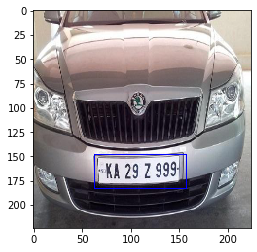

In [17]:
show_img(222)

In [10]:
!ls

 benchmarks		    'License Plate Detection.ipynb'
 indian_license_plates.csv   license_plate_detection.py
'Indian Number Plates'	     nu.png
 Indian_Number_plates.json   README.md
 Label_to_yolo.py


I created an `ImageDataGenerator` object from Keras to load batches of images to memory. This process is necessary because we do not have infinite memory in both RAM and GPU RAM. I splitted the data into two with a batch size of 32 images. One for training (80% of the data) and one for validation (20% of the data) during training. Validation is important to see if the model overfit to the training data.

## The Model

In [18]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    reduced_df,
    directory=cwd,
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    reduced_df,
    directory=cwd,
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="validation")

Found 609 validated image filenames.
Found 67 validated image filenames.


I created a relatively "not so deep" convolutional neural network. It have 8 convolutinal layers with 4 max pool layers and a fully connected network with 2 hidden layers.

In [21]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, CHANNEL)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 260       
Total params: 17,938,756
Trainable params: 3,224,068
Non-trainable params: 14,714,688
________________________________________________________

To find the minimum amount of step count to cover all the batches, the following equations are necessary. Mathematically;

$$
\text{Step size} = \lceil \frac{\text{Number of elements}}{\text{Batch Size}} \rceil
$$

In [22]:
STEP_SIZE_TRAIN = int(np.ceil(train_generator.n / train_generator.batch_size))
STEP_SIZE_VAL = int(np.ceil(validation_generator.n / validation_generator.batch_size))

print("Train step size:", STEP_SIZE_TRAIN)
print("Validation step size:", STEP_SIZE_VAL)

train_generator.reset()
validation_generator.reset()

Train step size: 20
Validation step size: 3


## Training

I used Adam to optimize the weights and mean squared error as my loss function.

In [23]:
adam = Adam(lr=0.0005)
model.compile(optimizer=adam, loss="mse")

In [26]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

In [24]:
history = model.fit_generator(train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=30)



Epoch 1/30
19/20 [===========================>..] - ETA: 4s - loss: 0.0277

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The model's success over the validation data is 80%. However, you can see that from the above figure, the training is stopped after 30th epoch. This may because of the low number of training samples or my model is not capable of learning such data. If you have an idea, please comment below.

## Tests

In [ ]:
model.evaluate_generator(validation_generator, steps=STEP_SIZE_VAL)

Remember that, we had picked five lucky test samples for visiual inspection. Here they are.

In [ ]:
for idx, row in df.iloc[lucky_test_samples].iterrows():    
    img = cv2.resize(cv2.imread("Indian Number Plates/" + row[0]) / 255.0, dsize=(WIDTH, HEIGHT))
    y_hat = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH
    
    xt, yt = y_hat[0], y_hat[1]
    xb, yb = y_hat[2], y_hat[3]
    
    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()

# Conclusion
The model defined above is a very simple toy model. The training is straightforward and tests may not be reliable since the dataset is so small. However, it proves a concept that you can find plates from images with a simple CNN. This network may be used as a part of other more complicated networks.

Thank you :)